## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% ls drive/MyDrive/colab_projects/nlp_from_dls/14_HW_Fine-Tuning_GPT_and_BERT/

 bertviz_repo/
 checkpoints/
'Copy of [homework_part1]GPT.ipynb'
'Copy of [homework_part2]BERT_for_text_classification.ipynb'
'Copy of [seminar]BERT_for_text_classification.ipynb'
 figures/
'[homework_part1]GPT.ipynb'
'[homework_part2]BERT_for_text_classification.ipynb'


In [3]:
% cd drive/MyDrive/colab_projects/nlp_from_dls/14_HW_Fine-Tuning_GPT_and_BERT/

/content/drive/.shortcut-targets-by-id/1xLQBaAinu05dFe4ZHLlCa9XhQYiiqh1q/colab_projects/nlp_from_dls/14_HW_Fine-Tuning_GPT_and_BERT


In [4]:
%ls

 bertviz_repo/
 checkpoints/
'Copy of [homework_part1]GPT.ipynb'
'Copy of [homework_part2]BERT_for_text_classification.ipynb'
'Copy of [seminar]BERT_for_text_classification.ipynb'
 figures/
'[homework_part1]GPT.ipynb'
'[homework_part2]BERT_for_text_classification.ipynb'


Install Hugging Face transformers.

In [5]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 2.1MB 9.1MB/s 
     |████████████████████████████████| 225kB 37.9MB/s 
     |████████████████████████████████| 3.3MB 55.1MB/s 
     |████████████████████████████████| 901kB 58.4MB/s 
     |████████████████████████████████| 245kB 53.3MB/s 
     |████████████████████████████████| 112kB 59.2MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [6]:
import os

import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn
from torch.nn import functional as F

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [8]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681. Subsequent calls will reuse this data.


Посмотри, из чего состоит `emotion_dataset`:

In [9]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [10]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [11]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [12]:
emotion_dataset["train"]["label"][0]

0

In [13]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [14]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")

# GPT-2 does not have pad tokens. Instead, we'll use the EOS (end of sentense) tokens.
# У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.
tokenizer.pad_token = tokenizer.eos_token

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [15]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [16]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [17]:
# with encode_plus generate attention masks
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [18]:
# endode_plus has an option to generate PyTorch (pt) tensors straight away
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [19]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128,       # max text length
    padding="max_length", # how much padding
    return_tensors="pt",  # returns pytorch tensors
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [20]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [21]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
            text, 
            max_length=self.max_length,  # max text length
            padding="max_length",   # how much padding
            return_tensors="pt",    # returns pytorch tensors, other options available
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [22]:
train_dataset = TweetDataset(part='train')
valid_dataset = TweetDataset(part='validation')
test_dataset  = TweetDataset(part='test')

In [37]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

16000
2000
2000


In [23]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False,
)

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [24]:
batch = next(iter(train_loader))
batch

{'input_ids': tensor([[[   72,  1816,   284,  ..., 50256, 50256, 50256]],
 
         [[   72,   635,  1464,  ..., 50256, 50256, 50256]],
 
         [[   72,  4327,   284,  ..., 50256, 50256, 50256]],
 
         ...,
 
         [[   72,   481,  1560,  ..., 50256, 50256, 50256]],
 
         [[   72,  1254,   588,  ..., 50256, 50256, 50256]],
 
         [[   72,  1254, 14709,  ..., 50256, 50256, 50256]]]),
 'mask': tensor([[[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         ...,
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0]]]),
 'target': tensor([1, 4, 3, 3, 5, 1, 1, 1, 0, 1, 3, 3, 1, 3, 0, 5, 1, 4, 0, 0, 1, 4, 3, 1,
         0, 1, 0, 0, 4, 1, 3, 0, 0, 3, 1, 0, 3, 1, 1, 3, 1, 3, 3, 0, 0, 1, 0, 0,
         3, 1, 3, 3, 0, 3, 0, 4, 0, 0, 2, 1, 5, 1, 3, 3])}

In [25]:
# [batch size, 1, max seq len], [batch size, max seq len]
batch['input_ids'].shape, batch['input_ids'].squeeze(1).shape

(torch.Size([64, 1, 128]), torch.Size([64, 128]))

In [26]:
# [batch size, 1, max seq len], [batch size, max seq len]
batch['mask'].shape, batch['mask'].squeeze(1).shape

(torch.Size([64, 1, 128]), torch.Size([64, 128]))

In [27]:
batch['target'].shape # [batch size]

torch.Size([64])

## Training From Scratch

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [28]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6 # originally was 8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [112]:
# model_0

Подготовь оптимайзер и критерий:

In [30]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr)

scheduler

In [31]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Alternatively can follow the recommendations from https://huggingface.co/transformers/training.html to set optimizer and scheduler.

criterion

In [32]:
criterion_mean = nn.CrossEntropyLoss(reduction='mean') # default
criterion_sum =  nn.CrossEntropyLoss(reduction='sum') # will use

In [33]:
tokens = batch['input_ids'].squeeze(1).to(device) # Получи токены из датасета
mask = batch['mask'].squeeze(1).to(device) # Получи маску из датасета
targets = batch['target'].to(device)

# out is an objects with many attributes, see documentation
# https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification
with torch.no_grad():
    outputs = model_0(input_ids=tokens, attention_mask=mask, labels=targets) # Посмотри на аутпут

Note, passing labels was optional. Let's have a look at predictions.

In [34]:
# [batch size, n classes]
outputs.logits.shape

torch.Size([64, 6])

Logits are not normalized.

In [35]:
outputs.logits.sum(1)

tensor([ 0.6746,  1.0421,  2.2942,  0.3064,  0.2000, -0.3408,  0.9175,  1.4682,
        -0.0936,  1.2329,  0.3336,  0.6032,  1.3081,  1.6000, -1.8901, -0.4499,
        -0.3666, -0.1578, -0.0782,  0.4913,  2.3013, -0.0087,  1.0730,  0.5741,
        -0.4495,  0.2855,  0.5522,  1.2215,  0.5617, -0.1185,  0.2662,  0.3398,
        -0.5264, -1.2958,  0.3991,  1.2987, -0.0055,  1.1267, -0.0398,  1.2637,
        -0.1959, -0.9467, -0.6177,  1.4204, -1.0742,  2.3036,  2.3000, -0.1394,
         1.0943,  0.8336,  0.2599,  0.7574, -0.4289,  1.6317,  1.3842, -1.0850,
         1.0761,  1.3235, -0.2188,  1.3211,  0.1813,  0.4180,  0.5718,  1.3556],
       device='cuda:0')

We can normalize with softmax, or use a loss that takes true labels and unnormalized logits.

In [36]:
torch.softmax(outputs.logits, dim=1).sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')

In [39]:
criterion_mean(input=outputs.logits, target=targets), criterion_sum(input=outputs.logits, target=targets)

(tensor(1.7423, device='cuda:0'), tensor(111.5067, device='cuda:0'))

Note, that we could just pass the labels into the model and get the loss (mean reduction):

In [40]:
# same as CrossEntropyLoss(logit, labels) with 'mean' reduction
outputs.loss

tensor(1.7423, device='cuda:0')

This is supposed to be exactly the same as calling `F.cross_entropy()`

In [41]:
F.cross_entropy(outputs.logits, targets), F.cross_entropy(outputs.logits, targets, reduction='sum')

(tensor(1.7423, device='cuda:0'), tensor(111.5067, device='cuda:0'))

All 3 methods give exactly the same results, but the PyTorch ones have a flexibility of `resuction='sum'`, which is needed if the total number of samples in not divisible by the `batch_size`.



Calculating accuracy

In [42]:
print(torch.argmax(outputs.logits, dim=1).shape) # [batch size]

preds = torch.argmax(outputs.logits, dim=1)
preds

torch.Size([64])


tensor([5, 3, 3, 3, 5, 1, 0, 1, 0, 1, 3, 1, 1, 4, 0, 5, 0, 1, 0, 2, 1, 3, 3, 2,
        2, 0, 3, 1, 3, 1, 0, 5, 0, 5, 1, 3, 2, 3, 4, 5, 1, 3, 1, 3, 3, 0, 1, 1,
        3, 3, 2, 3, 5, 2, 3, 1, 1, 1, 0, 1, 2, 3, 3, 5], device='cuda:0')

In [43]:
(preds == targets).to(torch.float).mean()

tensor(0.3594, device='cuda:0')

Note, since the last batch might be smaller, it is good to use 'sum' reduction for all recorded statistics and then divide by the total number of examples in the train/valid/test sets.

In [44]:
TRAIN_TOTAL = len(train_dataset)
VALID_TOTAL = len(valid_dataset)
TEST_TOTAL  = len(test_dataset)

print(TRAIN_TOTAL, VALID_TOTAL, TEST_TOTAL)

16000 2000 2000


Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [45]:
for e in tqdm(range(3)):
    print(f'\nEpoch {e:02}')

    for batch in tqdm(range(250)):
        if batch % 50 == 0:
            print('\tbatch', batch)
            time.sleep(.5)

    print(f'\tTrain loss {np.random.uniform() :.3}')
    time.sleep(1)


Epoch 00


	batch 0
	batch 50
	batch 100
	batch 150
	batch 200

	Train loss 0.355

Epoch 01


	batch 0
	batch 50
	batch 100
	batch 150
	batch 200

	Train loss 0.144

Epoch 02


	batch 0
	batch 50
	batch 100
	batch 150
	batch 200

	Train loss 0.924



### Training

In [74]:
TRAIN_FROM_SCRATCH = False

In [75]:
NUM_EPOCHS = 10
PATIENCE = 3
MODEL_NAME = 'gpt_from_scratch'

In [76]:
if TRAIN_FROM_SCRATCH:
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []
    state = {}

    best_epoch = 0
    curr_patience = 0

    best_acc = 0
    best_loss = np.Inf
    # ==============================================================================


    # Train-validation loop
    for epoch in tqdm(range(NUM_EPOCHS)):
        print(f'\nEpoch {epoch:02}')

        # --------------------------------------------------------------------------
        # Training
        # --------------------------------------------------------------------------
        train_loss = 0
        train_correct = 0
        model_0.train()
        for batch in tqdm(train_loader):
            tokens = batch['input_ids'].squeeze(1).to(device) # [batch size, max seq len]
            masks = batch['mask'].squeeze(1).to(device)       # [batch size, max seq len]
            labels = batch['target'].to(device)              # [batch size]

            # passing labels is optional, but it gives a .loss attribute to the output (only reduction='mean' available)
            outputs = model_0(input_ids=tokens, attention_mask=masks)
            # calculate loss with reduction='sum'
            loss = criterion_sum(outputs.logits, labels)

            # zero gradient + backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the learning rate here or after the validation
            # scheduler.step()

            # passes a float and does not carry the computational graph
            train_loss += loss.item()

            # calculate accuracy, no need for softmax since it's an increasing function
            # note, logits are not normalized, but this is fine when using most of cross-entropy losses in PyTorch
            preds = torch.argmax(outputs.logits, dim=1).detach()
            # sum reduction for exact calculation
            train_correct += (preds == labels).to(torch.float).sum()

            # # (for debugging)
            # break


        # record history and print
        # loss
        train_average_epoch_loss = train_loss / TRAIN_TOTAL
        train_loss_history.append(train_average_epoch_loss)
        print(f"\tTrain Loss: {train_average_epoch_loss:.3}")
        # accuracy
        train_average_epoch_acc = train_correct / TRAIN_TOTAL
        train_acc_history.append(train_average_epoch_acc)
        print(f"\tTrain Acc : {train_average_epoch_acc:.3}")

        # --------------------------------------------------------------------------
        # Validation
        # --------------------------------------------------------------------------
        valid_loss = 0
        valid_correct = 0
        model_0.eval()
        with torch.no_grad():
            for batch in valid_loader:
                tokens = batch['input_ids'].squeeze(1).to(device)
                masks = batch['mask'].squeeze(1).to(device)
                labels = batch['target'].to(device)

                outputs = model_0(input_ids=tokens, attention_mask=masks)

                # calculate loss, reduction='sum'
                loss = criterion_sum(outputs.logits, labels)
                valid_loss += loss.item()

                # calculate accuracy, no need for softmax since it's an increasing function
                preds = torch.argmax(outputs.logits, dim=1).detach()

                # sum reduction for exact calculation
                valid_correct += (preds == labels).to(torch.float).sum()
                
                # # (for debugging)
                # break

        # record history and print
        # loss
        valid_average_epoch_loss = valid_loss / VALID_TOTAL
        valid_loss_history.append(valid_average_epoch_loss)
        print(f"\tValid Loss: {valid_average_epoch_loss:.3}")
        # accuracy
        valid_average_epoch_acc = valid_correct / VALID_TOTAL
        valid_acc_history.append(valid_average_epoch_acc)
        print(f"\tValid Acc : {valid_average_epoch_acc:.3}")


        # # reduce the learning rate on platoe
        # scheduler.step(valid_acc)

        # --------------------------------------------------------------------------
        # Plotting
        # --------------------------------------------------------------------------
        plt.figure(figsize=(18, 9))
        plt.plot(np.arange(len(train_loss_history)), train_loss_history, label=f'Train, loss: {train_average_epoch_loss:.4f}, Acc: {train_average_epoch_acc:.4f}')
        plt.plot(np.arange(len(valid_loss_history)), valid_loss_history, label=f'Valid, loss: {valid_average_epoch_loss:.4f}, Acc: {valid_average_epoch_acc:.4f}')
        plt.title(f'Epoch {epoch}')
        plt.legend(loc='best')
        plt.show()

        # --------------------------------------------------------------------------
        # Saving checkpoints and early stopping
        # --------------------------------------------------------------------------

        # save if best results
        best_acc = max(best_acc, valid_average_epoch_acc)
        best_loss = min(best_loss, valid_average_epoch_loss)
        best_epoch = epoch if best_acc == valid_average_epoch_acc else best_epoch

        # record history
        state['train_losses'] = train_loss_history
        state['valid_losses'] = valid_loss_history
        state['train_accs'] = train_acc_history
        state['valid_accs'] = valid_acc_history
        

        if best_epoch == epoch:
            # reset patience
            curr_patience = 0

            # print('Saving..')
            state['weights'] = model_0.state_dict()
            state['acc'] = best_acc
            state['epoch'] = epoch

            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/ckpt_{MODEL_NAME}.pth')
        else:
            curr_patience += 1
            if curr_patience > PATIENCE:
                print('Early stopping:')
                print(f'\tCurrent epoch: {epoch:02}')
                print(f'\tBest epoch: {best_epoch:02}')
                break

    # reload the best model and save all the history, othw will loose last epochs
    state = torch.load(f'./checkpoints/ckpt_{MODEL_NAME}.pth')
    state['train_losses'] = train_loss_history
    state['valid_losses'] = valid_loss_history
    state['train_accs'] = train_acc_history
    state['valid_accs'] = valid_acc_history
    torch.save(state, f'./checkpoints/ckpt_{MODEL_NAME}.pth')

### Print info and Plot learning curves:

In [56]:
checkpoint = torch.load(f'./checkpoints/ckpt_{MODEL_NAME}.pth', map_location=torch.device(device))

best_epoch = checkpoint['epoch']
best_acc = checkpoint['acc'].item()

print('Best epoch:', best_epoch)
print(f'Validation Accuracy:', best_acc)

Best epoch: 12
Validation Accuracy: 0.8760000467300415


In [ ]:
#%mkdir ./figures/

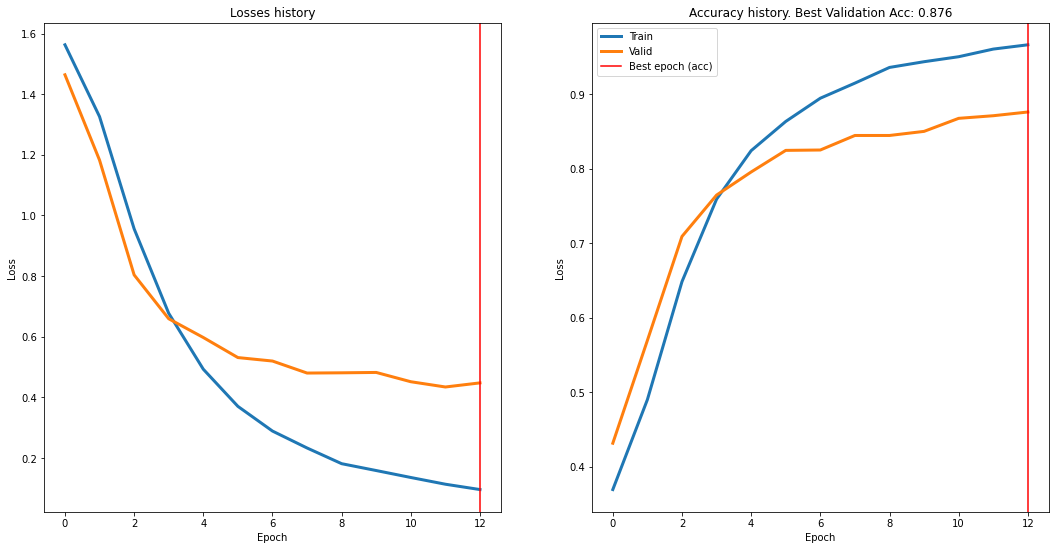

In [57]:
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']

train_accs = checkpoint['train_accs']
valid_accs = checkpoint['valid_accs']
best_acc = checkpoint['acc']

# plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

ax1.plot(np.arange(len(train_losses)), train_losses, label=f'Train', linewidth=3)
ax1.plot(np.arange(len(valid_losses)), valid_losses, label=f'Valid', linewidth=3)
ax1.axvline(x=best_epoch, label='Best epoch (acc)', color='red')
ax1.set_title(f'Losses history')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
#ax1.legend(loc='best')


ax2.plot(np.arange(len(train_accs)), train_accs, label=f'Train', linewidth=3)
ax2.plot(np.arange(len(valid_accs)), valid_accs, label=f'Valid', linewidth=3)
ax2.axvline(x=best_epoch, label='Best epoch (acc)', color='red')
ax2.set_title(f'Accuracy history. Best Validation Acc: {best_acc:.4}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')

plt.savefig(f"./figures/{MODEL_NAME}.svg")
plt.show()

### Testing

In [58]:
model_0.load_state_dict(torch.load(f'./checkpoints/ckpt_{MODEL_NAME}.pth')['weights'])

<All keys matched successfully>

In [59]:
# Testing
test_acc = 0
test_loss = 0

model_0.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        tokens = batch['input_ids'].squeeze(1).to(device)
        masks = batch['mask'].squeeze(1).to(device)
        labels = batch['target'].to(device)


        # passing labels is optional, but it gives a .loss attribute to the output
        outputs = model_0(input_ids=tokens, attention_mask=masks)

        # calculate loss and add sum of losses = mean * batch_len
        loss = criterion_sum(outputs.logits, labels)
        test_loss += loss.item()

        # calculate accuracy, no need for softmax since it's an increasing function
        preds = torch.argmax(outputs.logits, dim=1).detach()

        # sum-reduction for exact calculation
        test_acc += (preds == labels).to(torch.float).sum()

print(f"Test Loss: {test_loss / TEST_TOTAL:.4}\n",
      f"Test Acc: {test_acc / TEST_TOTAL:.4}")


Test Loss: 0.5283
 Test Acc: 0.8545


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
# model_0

Our version of GPT-2 contains **6 decoder layers** from transformer, with **12 masked multi-head attention heads** each.

In [61]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return seq, attn

In [62]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [102]:
emotion_dataset['test']['text'][42], emotion_dataset['test']['label'][42]

('i feel reassured that i am dealing with my diet in the right way and that all is good',
 1)

Visualize the attentions on this text.

In [64]:
text = emotion_dataset['test']['text'][42] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [65]:
seq, attns = get_attention_matrixes(model_0, tokenizer, text)

attns_np = np.array(attns)
attns_list = [torch.from_numpy(attns[i]).unsqueeze(0) for i in range(len(attns))]

print(len(seq))     # seq len (number of words)
print([attns_list[i].shape for i in range(len(attns_list))])
print(attns_np.shape)  # [num layers, num attention heads, seq len, seq len]

19
[torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19])]
(6, 12, 19, 19)


In [66]:
# bertviz shows which words the attention was paid to

import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [67]:
from bertviz import model_view
from transformers import GPT2Tokenizer, GPT2Model

In [68]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [69]:
call_html()
model_view(attns_list, seq)

<IPython.core.display.Javascript object>

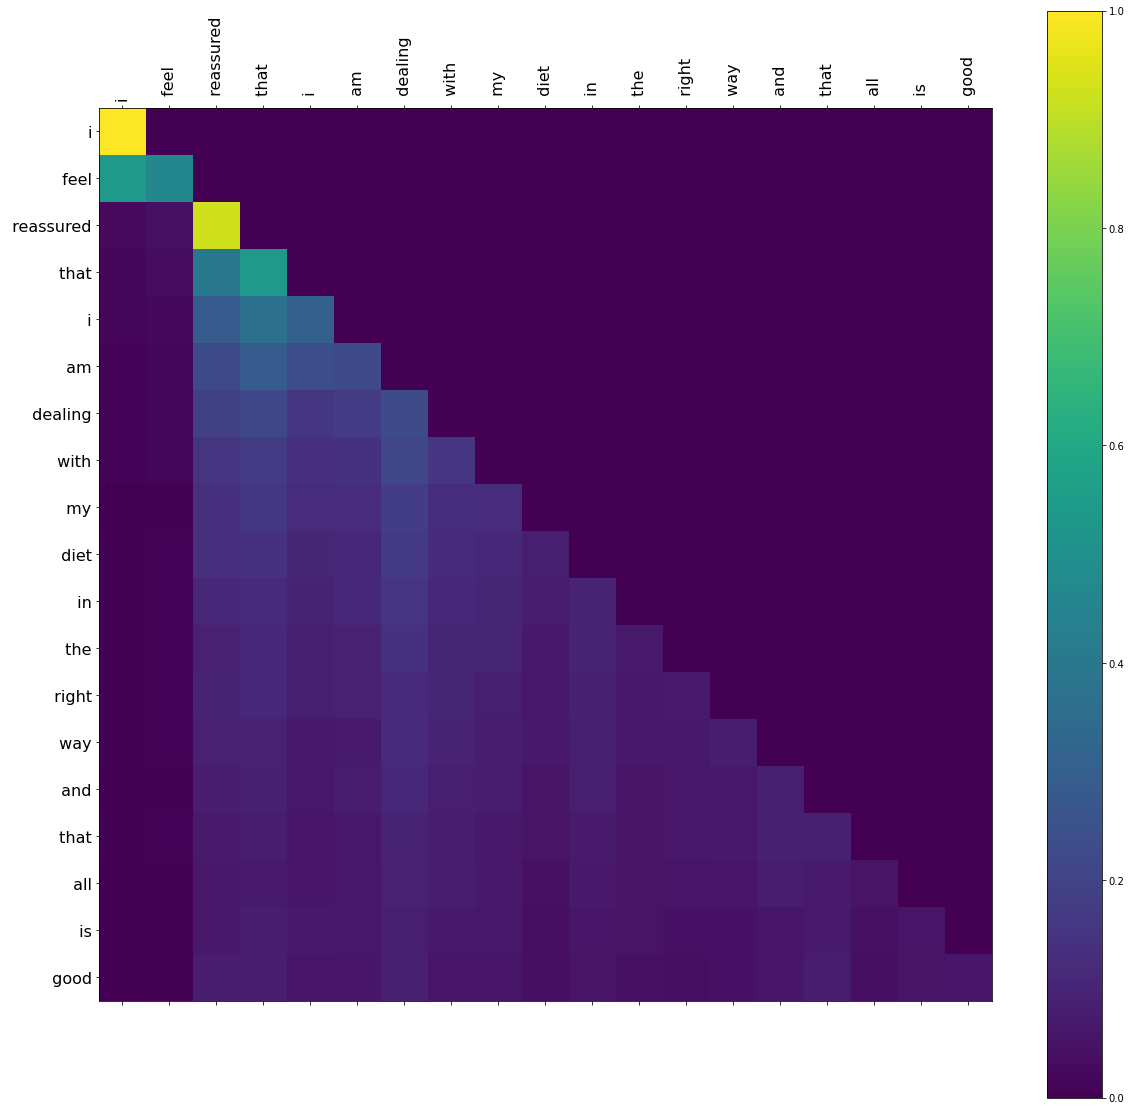

In [70]:
# choose a layer and head to look at
layer = 2
head = 3

show_attention(seq, attns_np[layer][head])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [89]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=lr)

In [91]:
NUM_EPOCHS = 20
PATIENCE = 3
MODEL_NAME = 'gpt_fine_tuned'

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [92]:
TRAIN_FINE_TUNE = True

In [ ]:
if TRAIN_FINE_TUNE:
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []
    state = {}

    best_epoch = 0
    curr_patience = 0

    best_acc = 0
    best_loss = np.Inf
    # ==============================================================================


    # Train-validation loop
    for epoch in tqdm(range(NUM_EPOCHS)):
        print(f'\nEpoch {epoch:02}')

        # --------------------------------------------------------------------------
        # Training
        # --------------------------------------------------------------------------
        train_loss = 0
        train_correct = 0
        model_1.train()
        for batch in tqdm(train_loader):
            tokens = batch['input_ids'].squeeze(1).to(device) # [batch size, max seq len]
            masks = batch['mask'].squeeze(1).to(device)       # [batch size, max seq len]
            labels = batch['target'].to(device)              # [batch size]

            # passing labels is optional, but it gives a .loss attribute to the output (only reduction='mean' available)
            outputs = model_1(input_ids=tokens, attention_mask=masks)
            # calculate loss with reduction='sum'
            loss = criterion_sum(outputs.logits, labels)

            # zero gradient + backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update the learning rate here or after the validation
            # scheduler.step()

            # passes a float and does not carry the computational graph
            train_loss += loss.item()

            # calculate accuracy, no need for softmax since it's an increasing function
            # note, logits are not normalized, but this is fine when using most of cross-entropy losses in PyTorch
            preds = torch.argmax(outputs.logits, dim=1).detach()
            # sum reduction for exact calculation
            train_correct += (preds == labels).to(torch.float).sum()

            # # (for debugging)
            # break


        # record history and print
        # loss
        train_average_epoch_loss = train_loss / TRAIN_TOTAL
        train_loss_history.append(train_average_epoch_loss)
        print(f"\tTrain Loss: {train_average_epoch_loss:.3}")
        # accuracy
        train_average_epoch_acc = train_correct / TRAIN_TOTAL
        train_acc_history.append(train_average_epoch_acc)
        print(f"\tTrain Acc : {train_average_epoch_acc:.3}")

        # --------------------------------------------------------------------------
        # Validation
        # --------------------------------------------------------------------------
        valid_loss = 0
        valid_correct = 0
        model_1.eval()
        with torch.no_grad():
            for batch in valid_loader:
                tokens = batch['input_ids'].squeeze(1).to(device)
                masks = batch['mask'].squeeze(1).to(device)
                labels = batch['target'].to(device)

                outputs = model_1(input_ids=tokens, attention_mask=masks)

                # calculate loss, reduction='sum'
                loss = criterion_sum(outputs.logits, labels)
                valid_loss += loss.item()

                # calculate accuracy, no need for softmax since it's an increasing function
                preds = torch.argmax(outputs.logits, dim=1).detach()

                # sum reduction for exact calculation
                valid_correct += (preds == labels).to(torch.float).sum()
                
                # # (for debugging)
                # break

        # record history and print
        # loss
        valid_average_epoch_loss = valid_loss / VALID_TOTAL
        valid_loss_history.append(valid_average_epoch_loss)
        print(f"\tValid Loss: {valid_average_epoch_loss:.3}")
        # accuracy
        valid_average_epoch_acc = valid_correct / VALID_TOTAL
        valid_acc_history.append(valid_average_epoch_acc)
        print(f"\tValid Acc : {valid_average_epoch_acc:.3}")


        # # reduce the learning rate on platoe
        # scheduler.step(valid_acc)

        # --------------------------------------------------------------------------
        # Saving checkpoints and early stopping
        # --------------------------------------------------------------------------

        # save if best results
        best_acc = max(best_acc, valid_average_epoch_acc)
        best_loss = min(best_loss, valid_average_epoch_loss)
        best_epoch = epoch if best_acc == valid_average_epoch_acc else best_epoch
        
        # --------------------------------------------------------------------------
        # Plotting
        # --------------------------------------------------------------------------
        # plot
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

        ax1.plot(np.arange(len(train_loss_history)), train_loss_history, label=f'Train', linewidth=3)
        ax1.plot(np.arange(len(valid_loss_history)), valid_loss_history, label=f'Valid', linewidth=3)
        ax1.axvline(x=best_epoch, label='Best epoch (acc)', color='red')
        ax1.set_title(f'Losses history')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        #ax1.legend(loc='best')

        ax2.plot(np.arange(len(train_acc_history)), train_acc_history, label=f'Train', linewidth=3)
        ax2.plot(np.arange(len(valid_acc_history)), valid_acc_history, label=f'Valid', linewidth=3)
        ax2.axvline(x=best_epoch, label='Best epoch (acc)', color='red')
        ax2.set_title(f'Accuracy history. Best Validation Acc: {best_acc:.4}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='best')

        plt.show()

        # --------------------------------------------------------------------------
        # Saving checkpoints and early stopping
        # --------------------------------------------------------------------------

        # record history
        state['train_losses'] = train_loss_history
        state['valid_losses'] = valid_loss_history
        state['train_accs'] = train_acc_history
        state['valid_accs'] = valid_acc_history

        if best_epoch == epoch:
            # reset patience
            curr_patience = 0

            # print('Saving..')
            state['weights'] = model_1.state_dict()
            state['acc'] = best_acc
            state['epoch'] = epoch

            if not os.path.isdir('checkpoints'):
                os.mkdir('checkpoints')
            torch.save(state, f'./checkpoints/ckpt_{MODEL_NAME}.pth')
        else:
            curr_patience += 1
            if curr_patience > PATIENCE:
                print('Early stopping:')
                print(f'\tCurrent epoch: {epoch:02}')
                print(f'\tBest epoch: {best_epoch:02}')
                break

    # reload the best model and save all the history, othw will loose last epochs
    state = torch.load(f'./checkpoints/ckpt_{MODEL_NAME}.pth')
    state['train_losses'] = train_loss_history
    state['valid_losses'] = valid_loss_history
    state['train_accs'] = train_acc_history
    state['valid_accs'] = valid_acc_history
    torch.save(state, f'./checkpoints/ckpt_{MODEL_NAME}.pth')

In [94]:
    # reload the best model and save all the history, othw will loose last epochs
    state = torch.load(f'./checkpoints/ckpt_{MODEL_NAME}.pth')
    state['train_losses'] = train_loss_history
    state['valid_losses'] = valid_loss_history
    state['train_accs'] = train_acc_history
    state['valid_accs'] = valid_acc_history
    torch.save(state, f'./checkpoints/ckpt_{MODEL_NAME}.pth')

In [110]:
checkpoint = torch.load(f'./checkpoints/ckpt_{MODEL_NAME}.pth', map_location=torch.device(device))

best_epoch = checkpoint['epoch']
best_acc = checkpoint['acc'].item()

print('Best epoch:', best_epoch)
print(f'Validation Accuracy:', best_acc)

Best epoch: 6
Validation Accuracy: 0.9295000433921814


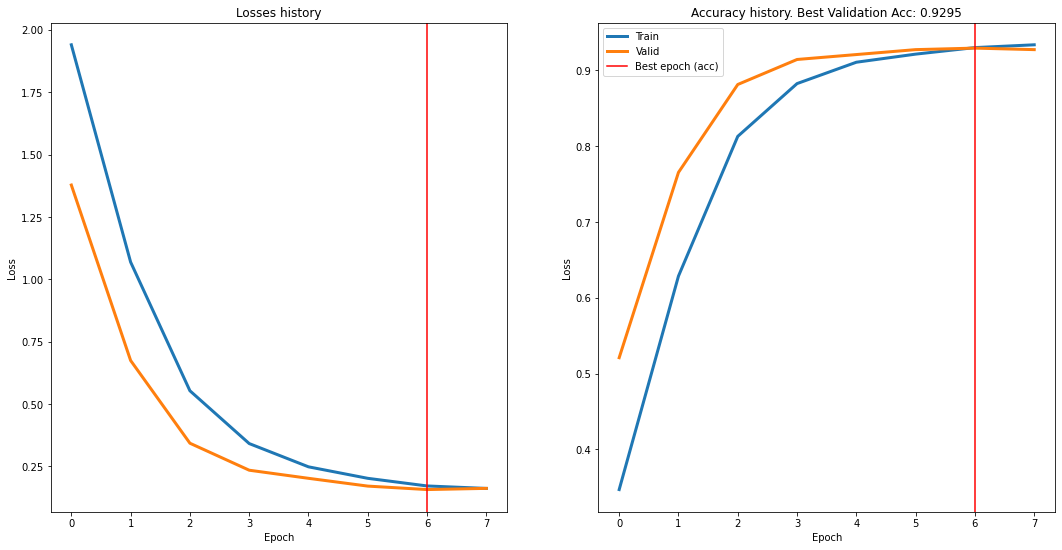

In [111]:
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']

train_accs = checkpoint['train_accs']
valid_accs = checkpoint['valid_accs']
best_acc = checkpoint['acc']

# plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

ax1.plot(np.arange(len(train_losses)), train_losses, label=f'Train', linewidth=3)
ax1.plot(np.arange(len(valid_losses)), valid_losses, label=f'Valid', linewidth=3)
ax1.axvline(x=best_epoch, label='Best epoch (acc)', color='red')
ax1.set_title(f'Losses history')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
#ax1.legend(loc='best')


ax2.plot(np.arange(len(train_accs)), train_accs, label=f'Train', linewidth=3)
ax2.plot(np.arange(len(valid_accs)), valid_accs, label=f'Valid', linewidth=3)
ax2.axvline(x=best_epoch, label='Best epoch (acc)', color='red')
ax2.set_title(f'Accuracy history. Best Validation Acc: {best_acc:.4}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')

plt.savefig(f"./figures/{MODEL_NAME}.svg")
plt.show()

In [95]:
model_1.load_state_dict(torch.load(f'./checkpoints/ckpt_{MODEL_NAME}.pth')['weights'])

<All keys matched successfully>

In [96]:
# Testing
test_acc = 0
test_loss = 0

model_1.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        tokens = batch['input_ids'].squeeze(1).to(device)
        masks = batch['mask'].squeeze(1).to(device)
        labels = batch['target'].to(device)


        # passing labels is optional, but it gives a .loss attribute to the output
        outputs = model_1(input_ids=tokens, attention_mask=masks)

        # calculate loss and add sum of losses = mean * batch_len
        loss = criterion_sum(outputs.logits, labels)
        test_loss += loss.item()

        # calculate accuracy, no need for softmax since it's an increasing function
        preds = torch.argmax(outputs.logits, dim=1).detach()

        # sum-reduction for exact calculation
        test_acc += (preds == labels).to(torch.float).sum()

print(f"Test Loss: {test_loss / TEST_TOTAL:.4}\n",
      f"Test Acc: {test_acc / TEST_TOTAL:.4}")


Test Loss: 0.1706
 Test Acc: 0.926


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [103]:
emotion_dataset['test']['text'][42], emotion_dataset['test']['label'][42] 

('i feel reassured that i am dealing with my diet in the right way and that all is good',
 1)

In [97]:
seq, attns = get_attention_matrixes(model_1, tokenizer, text)

attns_np = np.array(attns)
attns_list = [torch.from_numpy(attns[i]).unsqueeze(0) for i in range(len(attns))]

print(len(seq))     # seq len (number of words)
print([attns_list[i].shape for i in range(len(attns_list))])
print(attns_np.shape)  # [num layers, num attention heads, seq len, seq len]

19
[torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19]), torch.Size([1, 12, 19, 19])]
(6, 12, 19, 19)


In [98]:
call_html()
model_view(attns_list, seq)

<IPython.core.display.Javascript object>

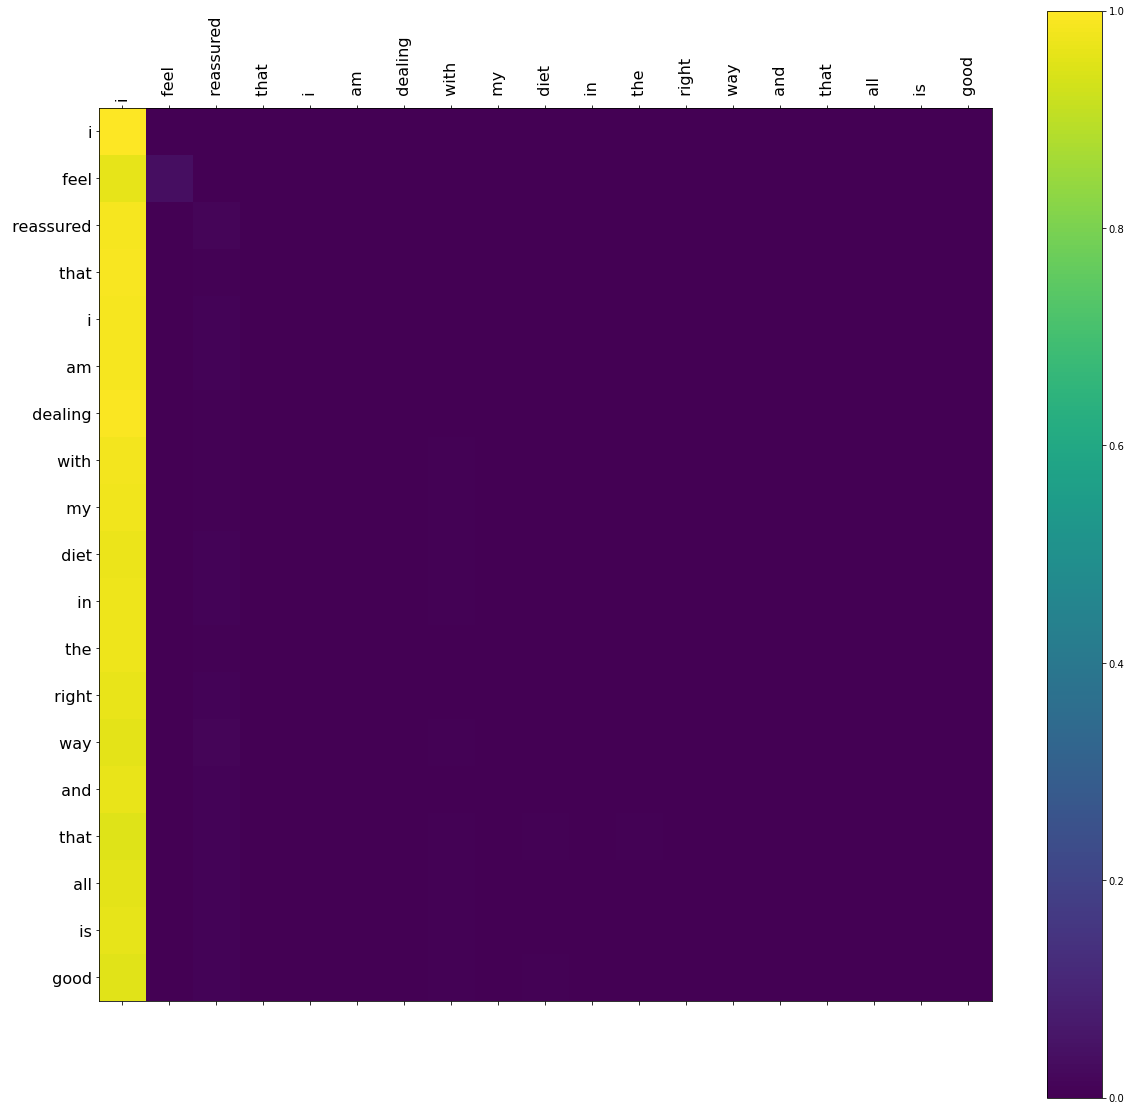

In [109]:
# choose a layer and head to look at
layer = 5
head = 2

# first word
show_attention(seq, attns_np[layer][head])

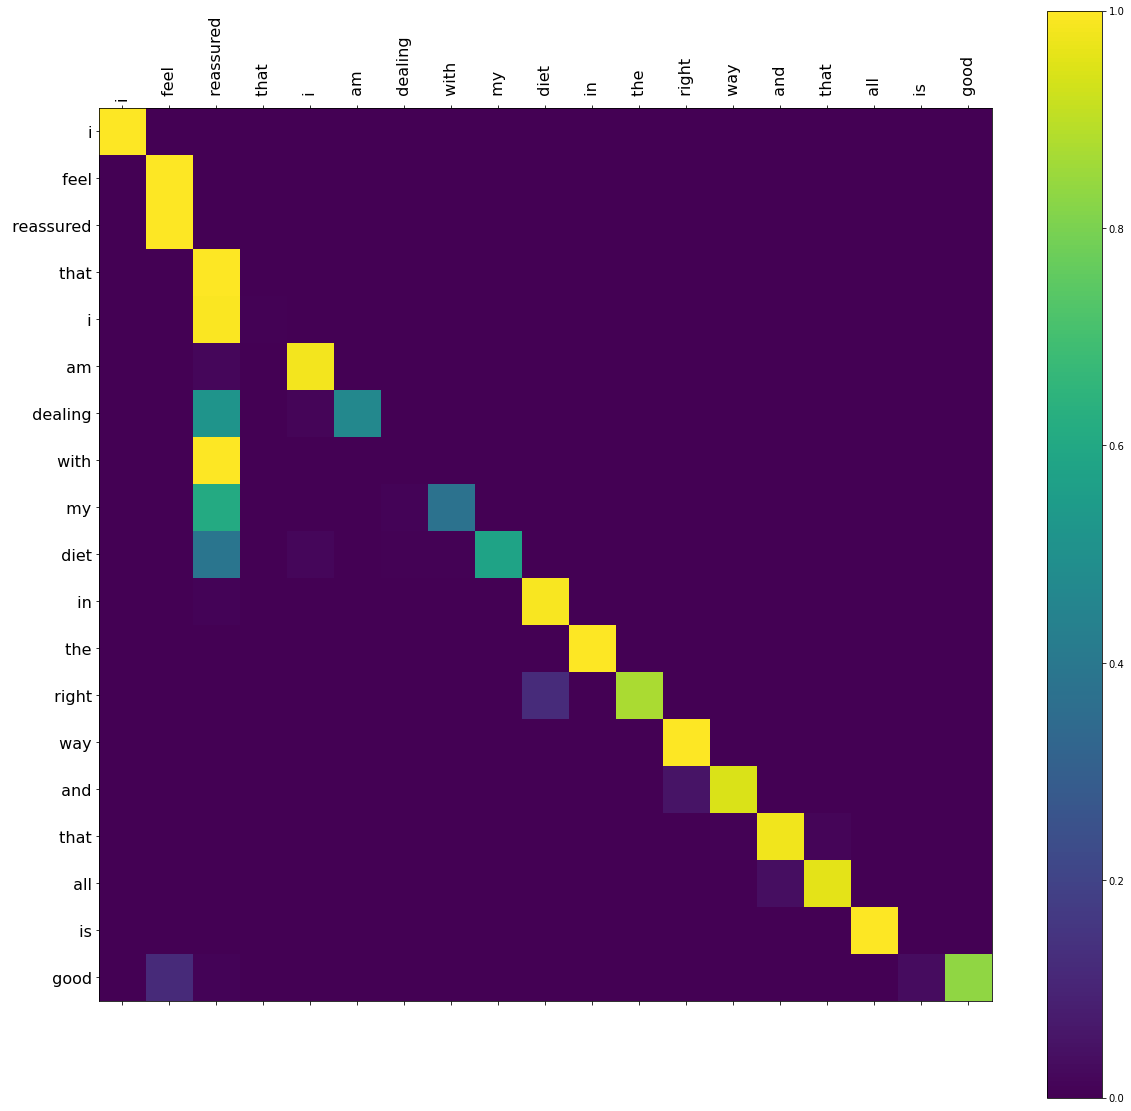

In [108]:
# choose a layer and head to look at
layer = 2
head = 11

# previous word
show_attention(seq, attns_np[layer][head])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше?
    * Использовать pre-trained model лучше (acc=92.5% vs acc=85.5%)
- На какие слова модель большего всего обращала внимание?
    * В pre-trained model больше разных голов в разных слоях. Много голов в разных слоях обращают внимание на первое слово. Но есть и другие (сморти следующий ответ).
- На каких слоях/головах модель обращала внимание?
    * Голова 11 в слое 2 (0-based counting) обращает внимание на предыдущее слово. Голова 5 в слое 2 (0-based counting) обращает внимание на первое и 3 слова (I, reassured).